In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
import cvlib as cv

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [14]:
DATADIR = "C:/Users/ATLAS PRO ELECTRO/Desktop/PFE/gender classification/data"

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATADIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(50, 50),
  batch_size=32)

Found 52217 files belonging to 2 classes.
Using 41774 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
   DATADIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(50, 50),
  batch_size=32)

Found 52217 files belonging to 2 classes.
Using 10443 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['men', 'women']


In [18]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [19]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(50, 
                                                              50,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [23]:
model = Sequential([data_augmentation,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(50,50, 3)),
                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(pool_size=(3,3)),
                    layers.Dropout(0.25),

                    layers.Conv2D(64, 3, padding="same" ,activation="relu"),
                    layers.Conv2D(128, 3, padding="same" ,activation="relu"),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.25),
                    layers.Conv2D(256, 3, padding="same" ,activation="relu"),
                    layers.Conv2D(512, 3, padding="same" ,activation="relu"),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.25),

                    layers.Flatten(),
                    layers.Dense(512, activation='relu'),
                    layers.Dropout(0.25),
                    
                    layers.Dense(2)
                   ])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 50, 50, 3)         0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)      

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [62]:
model.save('gender.h5')
model.save('gender.model')

INFO:tensorflow:Assets written to: gender.model\assets


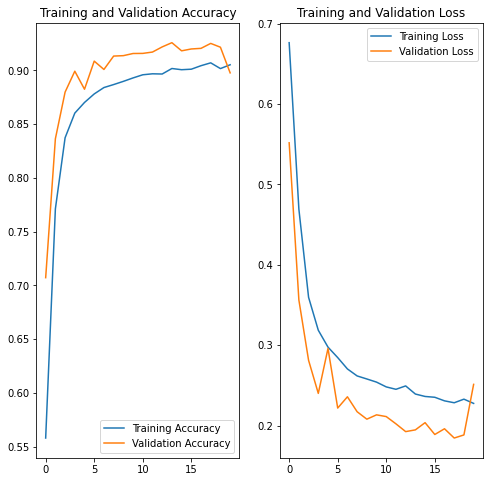

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

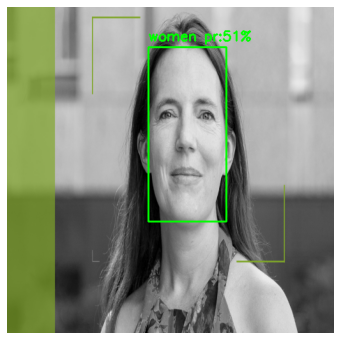

In [3]:
class_names=['men', 'women']
model = tf.keras.models.load_model("gender.h5")
image_path = "C:/Users/ATLAS PRO ELECTRO/Desktop/PFE/Gender-Detection-Using-Deep-Learning-main/e.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512))
face, confidence = cv.detect_face(img)
for  f in face :
    (startX, startY)=f[0], f[1]
    (endX, endY)= f[2], f[3]
    if (f[2] > 512 or f[3] > 512):
        break
    cv2.rectangle(img, (startX,startY), (endX,endY), (0,255,0), 2)
    
    face_crop = np.copy(img[startY:endY,startX:endX])
    
    face_crop = cv2.resize(face_crop, (50,50))
    face_crop = np.array(face_crop)
    face_crop = np.expand_dims(face_crop, 0)
    
    cf = model.predict(face_crop)
    
    score = tf.nn.sigmoid(cf[0])
    label = class_names[np.argmax(score)]
    idx = 100 * np.max(score)
    label = label +" pr:"+ str(int(idx))+"%"
    Y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(img, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (0, 255, 0), 2)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.show()